The goal of this notebook is to develop code to generate training data for training a UNet or similar. The code from here will then be adapted to some "production" code. 

The training data will look like this:

1. input: pair of images of 4xWxH from before and after
    - these can come from the 'before' and 'after' periods (ie. many possible combinations) or also from various mosaics of them
    - these will be merged in some way; the vanilla merge method is concat; better methods can include trainable merge
    - later it can be more than 2 images, e.g. it can be 3 from each before and after 
2. label: image of 1xWxH with binary label - deforestation or not for a particular date (as per the DETER polygon specified date)
    - this will be created by rasterization of DETER polygons, either a single one or multiple grouped by e.g. week or month


In [38]:
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt

from shapely.geometry import box
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import get_data_window, transform, shape
import geopandas as gpd

In [6]:
raster_paths = '../data/aoi_1/raster/2019_2021'
deter_path = '../data/sample_data/DETER/deter_public.shp'
aoi_path = '../data/aoi_1/vector/aoi_1.geojson'

In [7]:
deter = gpd.read_file(deter_path)
aoi = gpd.read_file(aoi_path).to_crs(deter.crs)
deter_aoi = gpd.clip(deter, aoi)
deter_aoi['date'] = deter_aoi["VIEW_DATE"].astype("datetime64")

In [8]:
deter_aoi_2019_21 = deter_aoi[(deter_aoi['date'] > "2019-01-01") & (deter_aoi['date'] < "2022-01-01")]
deter_aoi_2019_21

,CLASSNAME,QUADRANT,PATH_ROW,VIEW_DATE,SENSOR,SATELLITE,AREAUCKM,UC,AREAMUNKM,MUNICIPALI,GEOCODIBGE,UF,geometry,date
1384,DESMATAMENTO_CR,None,168105,2021-10-03,AWFI,CBERS-4,0.0,None,0.290930,Altamira,1500602,PA,"POLYGON ((-53.64143 -5.86984, -53.64900 -5.868...",2021-10-03
1985,DEGRADACAO,None,036016,2021-10-05,WFI,AMAZONIA-1,0.0,None,0.221640,Altamira,1500602,PA,"POLYGON ((-53.76300 -5.87785, -53.76271 -5.877...",2021-10-05
2025,DEGRADACAO,None,163111,2021-07-06,AWFI,CBERS-4,0.0,None,0.077628,Altamira,1500602,PA,"POLYGON ((-53.65610 -6.15209, -53.65584 -6.152...",2021-07-06
2031,DEGRADACAO,None,036016,2021-10-05,WFI,AMAZONIA-1,0.0,None,0.674434,Altamira,1500602,PA,"POLYGON ((-53.67105 -5.80741, -53.67088 -5.807...",2021-10-05
2036,DESMATAMENTO_CR,None,036016,2021-10-05,WFI,AMAZONIA-1,0.0,None,1.188350,Altamira,1500602,PA,"POLYGON ((-53.64364 -6.15132, -53.64339 -6.151...",2021-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247371,DESMATAMENTO_CR,None,165105,2020-08-22,AWFI,CBERS-4,0.0,None,0.092532,Altamira,1500602,PA,"POLYGON ((-53.51657 -6.13940, -53.51679 -6.139...",2020-08-22
247374,DESMATAMENTO_CR,None,165105,2020-08-22,AWFI,CBERS-4,0.0,None,0.090413,Altamira,1500602,PA,"POLYGON ((-53.51787 -6.18079, -53.51484 -6.182...",2020-08-22
247377,DESMATAMENTO_CR,None,165105,2020-08-22,AWFI,CBERS-4,0.0,None,0.164874,Altamira,1500602,PA,"POLYGON ((-53.57832 -6.10408, -53.57751 -6.103...",2020-08-22
247397,DESMATAMENTO_CR,None,165105,2020-08-22,AWFI,CBERS-4,0.0,None,0.095500,Altamira,1500602,PA,"POLYGON ((-53.56290 -6.08856, -53.56290 -6.089...",2020-08-22


<AxesSubplot:xlabel='date'>

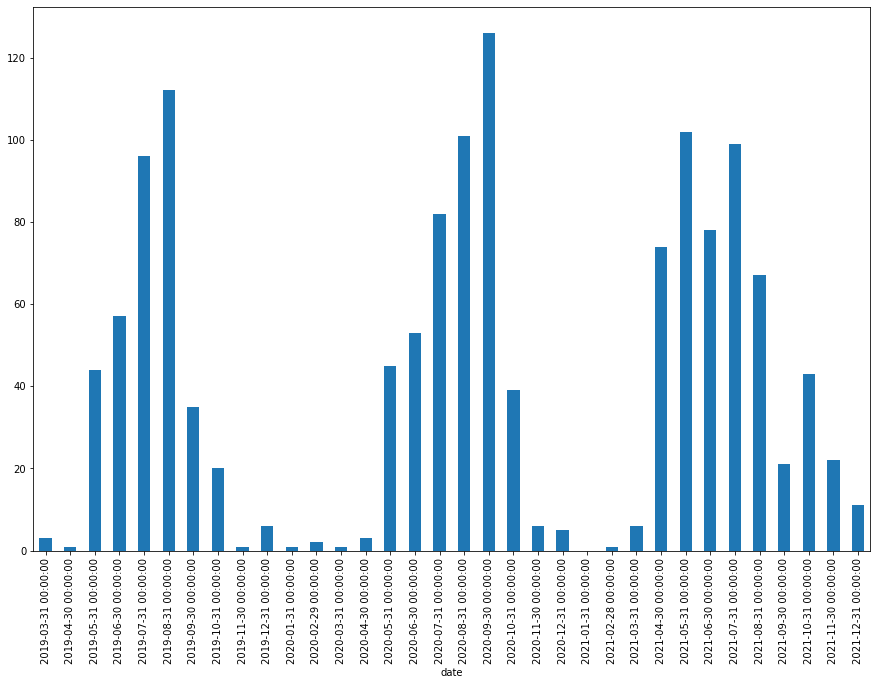

In [9]:
deter_aoi_2019_21.set_index('date', inplace=True)
deter_aoi_2019_21.resample('M').size().plot.bar(figsize=(15,10))


In [10]:
# here i just randomly selected a single polygon 

sample = deter_aoi_2019_21.iloc[11:12].reset_index()
sample

,date,CLASSNAME,QUADRANT,PATH_ROW,VIEW_DATE,SENSOR,SATELLITE,AREAUCKM,UC,AREAMUNKM,MUNICIPALI,GEOCODIBGE,UF,geometry
0,2020-08-25,DESMATAMENTO_CR,None,164105,2020-08-25,AWFI,CBERS-4,0.0,None,0.179314,Altamira,1500602,PA,"POLYGON ((-53.39948 -6.05016, -53.40000 -6.052..."


In [11]:
months_mapping = {"Jan" : "01",
                 "Feb" : "02",
                 "Mar" : "03",
                 "Apr" : "04",
                 "May" : "05",
                 "Jun" : "06",
                 "Jul" : "07",
                 "Aug" : "08",
                 "Sep" : "09",
                 "Oct" : "10",
                 "Nov" : "11",
                 "Dec" : "12"
                 }


2021Jul25


In [12]:
rasters = []

for file in os.listdir(raster_paths):
    if not file.endswith(".tif"):
        continue
    filename = Path(file).stem
    for key in months_mapping.keys():
        filename = filename.replace(key, months_mapping[key])
    date = pd.to_datetime(filename)
    filepath = os.path.join(raster_paths, file)
    rasters.append([date, filepath])


rasters_df = pd.DataFrame(rasters, columns=('date', 'path'))
rasters_df = rasters_df.sort_values(by='date')



In [14]:
before = rasters_df[rasters_df.date < sample.date.values[0]]
after = rasters_df[rasters_df.date > sample.date.values[0]]


In [15]:
before[-1:].path
after[:1]

,date,path
224,2020-08-26,../data/aoi_1/raster/2019_2021/2020Aug26.tif


In [20]:
# Function to normalize the grid values
def normalize(array):
    """Normalizes numpy arrays into scale 0.0 - 1.0"""
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

Normalized bands
0.0 - 1.0 mean: 0.12112714630372062
0.0 - 1.0 mean: 0.12756503812375863
0.0 - 1.0 mean: 0.1321974043554363


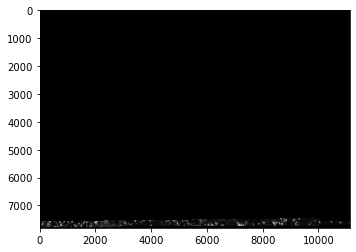

In [21]:
# As per https://automating-gis-processes.github.io/site/notebooks/Raster/plotting-raster.html 


with rasterio.open(before[-1:].path.values[0]) as src:

    # Read the grid values into numpy arrays
    red = src.read(3)
    green = src.read(2)
    blue = src.read(1)


    red = np.ma.array(red, mask=np.isnan(red))
    green = np.ma.array(green, mask=np.isnan(green))
    blue = np.ma.array(blue, mask=np.isnan(blue))

    # Normalize the bands
    redn = normalize(red)
    greenn = normalize(green)
    bluen = normalize(blue)

    print("Normalized bands")
    print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
    print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
    print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

    # Create RGB natural color composite
    rgb = np.dstack((redn, greenn, bluen))

    # Let's see how our color composite looks like
    plt.imshow(rgb)

In [ ]:
# Here i will select a subset of DETER within 1 week


# i think i shouldnt generate the samples based on the entire area but instead i need to stick to the DETER polygons and maybe their surroundings because
# otherwise i will have millions of undamaged tiles


# i also think there need to be 2 parameters for me to decide
# 1. how long after and before i will look
# 2. what is the margin around the DETER specified deforestation date
# i guess these i just need to find empirically
# for now i can start with 6 months before and after and 1 month before and after margin

#i guess in some cases (in the rain season) 6 months in one direction might not be enough, maybe these parameters could be expressed in terms of numbers
# of images used and not in time... but let's not complicate it 

In [ ]:
### here i am  probably gonna want to use the valid window as per gis stackexchange


'''

for a speed up i could add to my raster_df a column that would have the extent of the valid data of each raster
and also open all rasters and just fetch the rasterio dataset so that they are all open only once
'''

'''
for each DETER polygon:

    for raster in rasters:
        if in_time_window(raster, time_window,margin):
            if DETER within raster.valid.extent:
                rasters.append(raster)

    training_examples = mix_bef_and_after(rasters)
    label = DETER.rasterize

'''



In [23]:
rasters_df

,date,path
150,2019-01-02,../data/aoi_1/raster/2019_2021/2019Jan02.tif
176,2019-01-04,../data/aoi_1/raster/2019_2021/2019Jan04.tif
71,2019-01-09,../data/aoi_1/raster/2019_2021/2019Jan09.tif
151,2019-01-12,../data/aoi_1/raster/2019_2021/2019Jan12.tif
138,2019-01-17,../data/aoi_1/raster/2019_2021/2019Jan17.tif
...,...,...
162,2021-11-24,../data/aoi_1/raster/2019_2021/2021Nov24.tif
83,2021-11-29,../data/aoi_1/raster/2019_2021/2021Nov29.tif
158,2021-12-14,../data/aoi_1/raster/2019_2021/2021Dec14.tif
114,2021-12-22,../data/aoi_1/raster/2019_2021/2021Dec22.tif


In [ ]:
# As per https://automating-gis-processes.github.io/site/notebooks/Raster/plotting-raster.html 


with rasterio.open(before[-1:].path.values[0]) as src:

    # Read the grid values into numpy arrays
    red = src.read(3)
    green = src.read(2)
    blue = src.read(1)

    red = np.ma.array(red, mask=np.isnan(red))
    green = np.ma.array(green, mask=np.isnan(green))
    blue = np.ma.array(blue, mask=np.isnan(blue))

    # Normalize the bands
    redn = normalize(red)
    greenn = normalize(green)
    bluen = normalize(blue)

    print("Normalized bands")
    print(redn.min(), '-', redn.max(), 'mean:', redn.mean())
    print(greenn.min(), '-', greenn.max(), 'mean:', greenn.mean())
    print(bluen.min(), '-', bluen.max(), 'mean:', bluen.mean())

    # Create RGB natural color composite
    rgb = np.dstack((redn, greenn, bluen))


In [51]:
def clip_raster_to_valid(path):

    with rasterio.open(path) as src:
        profile = src.profile.copy()

        image_read = src.read()
        
        image_read_masked = np.ma.masked_array(image_read, mask=np.isnan(image_read))
        data_window = get_data_window(image_read_masked)
        data_transform = transform(data_window, src.transform)
        height, width = shape(data_window, profile['height'], profile['width'])
        profile.update(
            transform=data_transform,
            height=height,
            width=width)
        
        data = src.read(window=data_window)

    with rasterio.open(path.replace("2019_2021", "2019_2021_clip"), 'w', **profile) as sink:
        sink.write(data)

    #dataset = rasterio.open(path.replace("2019_2021", "2019_2021_clip")):

    #with rasterio.open(path.replace("2019_2021", "2019_2021_clip")) as src:
    #    geom = box(*src.bounds)   
    #return geom 

       
    

In [52]:
def mask_clouds(path):

    with rasterio.open(path) as src:

        data = src.read()
        profile = src.profile

    image = data[:-1]
    assert image.shape[0] == 4, f'expected 4 data channels, got {image.shape[0]}'
    image_valid = np.ma.array(image, mask=np.isnan(image))

    mask_2d = ~np.isin(data[-1], [1,3,7,8,9])
    mask_3d = np.broadcast_to(mask_2d, image_valid.shape)

    image_valid[~mask_3d] = np.nan

    profile.update(count=3)
    
    with rasterio.open(path.replace("clip", "processed"), "w", **profile) as sink:
        sink.write(image_valid)



In [55]:

subset = rasters_df[7:9].copy()

# here we write clipped rasters to new folder
subset['path'].apply(clip_raster_to_valid)


#subset['extent'] = subset['path'].apply(get_valid_extent)
subset




,date,path,extent
71,2019-01-09,../data/aoi_1/raster/2019_2021/2019Jan09.tif,"POLYGON ((256630 9297510, 256630 9373880, 2394..."
151,2019-01-12,../data/aoi_1/raster/2019_2021/2019Jan12.tif,"POLYGON ((256630 9297010, 256630 9374980, 1454..."


In [ ]:
'''
What I need to do next is to refactor the code that i have above so that the result is the clipped
image with nan-ed cloud areas.



'''